In [6]:
%matplotlib inline
import pandas as pd
from os.path import join as opj
from nipype.interfaces.io import DataSink
from nipype.interfaces.spm import (TwoSampleTTestDesign, EstimateModel,
                                   EstimateContrast)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

In [7]:
political_profile = pd.read_csv("/data/wellbeing_bids/subj_profile.tsv",delimiter='\t',encoding='utf-8')

In [17]:
import pickle
with open("/home/zohyos7/republicans_affect.txt", "rb") as fp:
    republicans = pickle.load(fp)
with open("/home/zohyos7/democrats_affect.txt", "rb") as fp:
    democrats = pickle.load(fp)
with open("/home/zohyos7/independents_affect.txt", "rb") as fp:
    independents = pickle.load(fp)

In [9]:
len(republicans)

44

In [10]:
len(democrats)

50

In [11]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [12]:
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

mask = "/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# TwoSampleTTestDesign - creates two sample T-Test Design
twosamplettestdes = Node(TwoSampleTTestDesign(),
                         name="twosampttestdes")

twosamplettestdes.inputs.group1_files = ['/data/wellbeing_analysis/datasink/antsflow/sub-%s/con/task-affect/fwhm-8/con_0008_trans.nii' % (rep)
                                         for rep in republicans]
twosamplettestdes.inputs.group2_files = ['/data/wellbeing_analysis/datasink/antsflow/sub-%s/con/task-affect/fwhm-8/con_0008_trans.nii' % (dem)
                                         for dem in democrats]

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Republicans', 'T', ['Group_{1}'], [1]]
cont2 = ['Democrats', 'T', ['Group_{2}'], [1]]
cont3 = ['Republicans > Democrats', 'T', ['Group_{1}','Group_{2}'], [1, -1]]
cont4 = ['Democrats > Republicans', 'T', ['Group_{1}','Group_{2}'], [-1, 1]]
level2conestimate.inputs.contrasts = [cont1, cont2, cont3, cont4]

# save data
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")



In [13]:
# Initiation of the 2nd-level analysis workflow
BL_two_sample = Workflow(name='BL_two_sample')
BL_two_sample.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
BL_two_sample.connect([(gunzip, twosamplettestdes, [('out_file','explicit_mask_file')]),
                    (twosamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2estimate, datasink, [('mask_image',
                                                 'BL_two_sample.@mask')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    'BL_two_sample.@spm_mat'),
                                                   ('spmT_images',
                                                    'BL_two_sample.@T'),
                                                   ('con_images',
                                                    'BL_two_sample.@con')])
                   ])



181114-13:58:41,153 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/BL_two_sample/graph.png (graph2use=colored, simple_form=True).


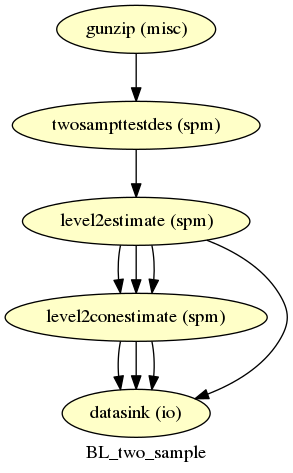

In [14]:
# Create 1st-level analysis output graph
BL_two_sample.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(BL_two_sample.base_dir, 'BL_two_sample', 'graph.png'))

In [16]:
BL_two_sample.run('MultiProc', plugin_args={'n_procs': 8})

181114-13:58:56,802 nipype.workflow INFO:
	 Workflow BL_two_sample settings: ['check', 'execution', 'logging', 'monitoring']
181114-13:58:56,816 nipype.workflow INFO:
	 Running in parallel.
181114-13:58:56,822 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
181114-13:58:56,918 nipype.workflow INFO:
	 [Job 0] Cached (BL_two_sample.gunzip).
181114-13:58:58,917 nipype.workflow INFO:
	 [Node] Outdated cache found for "BL_two_sample.twosampttestdes".
181114-13:58:59,0 nipype.workflow INFO:
	 [Node] Setting-up "BL_two_sample.twosampttestdes" in "/data/wellbeing_analysis/workingdir/BL_two_sample/twosampttestdes".
181114-13:58:59,8 nipype.workflow INFO:
	 [Node] Outdated cache found for "BL_two_sample.twosampttestdes".
181114-13:58:59,26 nipype.workflow INFO:
	 [Node] Running "twosampttestdes" ("nipype.interfaces.spm.model.TwoSampleTTestDesign")
181114-13:59:00,828 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks,

In [22]:
from nilearn.plotting import (plot_stat_map, plot_img)
%matplotlib inline
anatimg = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 4

## Analyzed with only previously used subjects

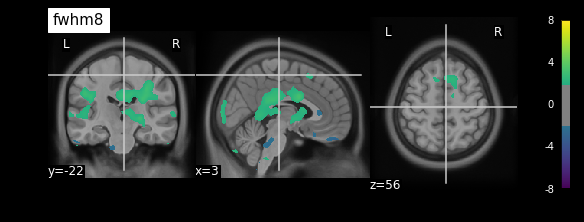

In [23]:
plot_stat_map(
    '/data/wellbeing_analysis/datasink/two_sample/task_affect/con08/spmT_0003.nii', title='fwhm8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='ortho', cut_coords=(3, -22, 56), cmap='viridis');

## Analyzed with more subjects (after checking mask image)

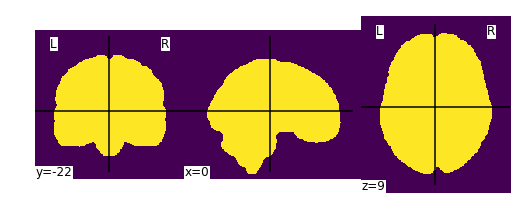

In [24]:
plot_img(
    '/data/wellbeing_analysis/datasink/two_sample2/task_affect/con08/mask.nii');

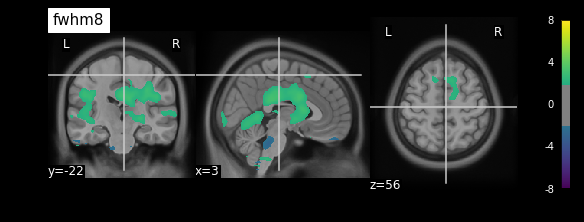

In [25]:
plot_stat_map(
    '/data/wellbeing_analysis/datasink/two_sample2/task_affect/con08/spmT_0003.nii', title='fwhm8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='ortho', cut_coords=(3, -22, 56), cmap='viridis');